DETR
====

**End-to-End Object Detection with Transformers**

 * Paper: https://arxiv.org/abs/2005.12872

![DETR Overview](../assets/detr_overview.png)

```bash
pip install torch torchvision
pip install transformers
pip install timm
pip install supervision
```

In [1]:
import warnings
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

import torch
import torch.nn.functional as F
from transformers import DetrFeatureExtractor, DetrForObjectDetection

warnings.filterwarnings("ignore", category=UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = DetrFeatureExtractor.from_pretrained(
    'facebook/detr-resnet-101-dc5'
)
model = DetrForObjectDetection.from_pretrained(
    'facebook/detr-resnet-101-dc5'
).eval().to(device);


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
Some weights of the model checkpoint at facebook/detr-resnet-101-dc5 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [2]:
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")

# Load and preprocess the image
inputs = feature_extractor(
    images=image, return_tensors="pt"
).to(device)

with torch.no_grad():
    outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes

logits.shape, bboxes.shape

(torch.Size([1, 100, 92]), torch.Size([1, 100, 4]))

In [3]:
# logits: shape [1, 100, 92]
probas = F.softmax(logits, dim=-1)

probas = probas[:, :, :-1]  # remove the "no-object" class
scores, labels = probas.max(-1)

threshold = 0.7
keep = scores[0] > threshold

filtered_boxes = bboxes[0][keep]
filtered_labels = labels[0][keep]
filtered_scores = scores[0][keep]

print(
    f"filtered_boxes: {filtered_boxes.shape}\n"
    f"filtered_labels: {filtered_labels.shape}\n"
    f"filtered_scores: {filtered_scores.shape}"
)

filtered_boxes: torch.Size([4, 4])
filtered_labels: torch.Size([4])
filtered_scores: torch.Size([4])


{np.int64(64): 0, np.int64(86): 1}
bboxes: (4, 4)


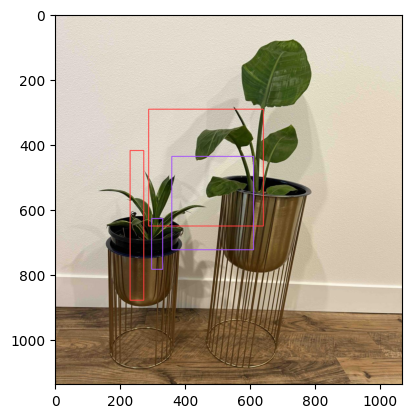

In [5]:
def visualize_bboxes(image, predictions):
    bboxes = predictions["boxes"]
    labels = predictions["labels"]
    #scores = predictions["scores"].cpu().numpy()
    uniq_labels = np.unique(labels)
    # map labels to class ids
    class_map = {label: i for i, label in enumerate(uniq_labels)}
    print(class_map)

    print("bboxes:", bboxes.shape)
    detections = sv.Detections(
        xyxy=bboxes,
        class_id=np.array([class_map[label] for label in labels]),
        #confidence=scores,
    )
    annotator = sv.BoxAnnotator()
    annotated_image = annotator.annotate(
        scene=image.copy(),
        detections=detections,
    )

    return annotated_image

w, h = image.size
img_size = np.array([w, h, w, h])
annotated_image = visualize_bboxes(image, {
    "boxes": filtered_boxes.cpu().numpy() * img_size,
    "labels": filtered_labels.cpu().numpy(),
})
plt.imshow(annotated_image)